In [1]:
from contextlib import redirect_stdout
import copy
import io
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import sys
import torch
from torch import nn
import tqdm

from utilities import *

%matplotlib inline
sns.set()

In [2]:
CUDA_LAUNCH_BLOCKING = '1'

negmax = lambda o, c: (ke.envs.connectx.connectx.negamax_agent(o,c),3)[sum(o.board)<7 and sum(o.board[-6:-1])<2]

## Agent and Network Definitions

In [3]:
class AgentNetwork(nn.Module):
    def __init__(self, path=None, load=False, use_cuda=True):
        super(AgentNetwork, self).__init__()
        
        self.path = path
        self.use_cuda = use_cuda
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU())
        
        self.advantages_layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU())
        self.advantages_dense = nn.Linear(192, N_ACTS)
        
        self.value_layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU())
        self.value_dense = nn.Linear(192, 1)
        
        if self.path and load:
            self.load()
            
        if use_cuda:
            self = self.cuda()
        
    def auto_correct_dtype(self, data):
        if isinstance(data, torch.Tensor):
            return data
        elif isinstance(data, np.ndarray):
            return torch.from_numpy(data)
        
        raise ValueError('Data for the NN must be either in numpy or tensor format!')
    
    def forward(self, obs):
        obs = self.auto_correct_dtype(obs).float()
        
        out = self.layer1(obs)
        out = self.layer2(out)
        
        advantages = self.advantages_layer3(out)
        advantages = advantages.view(-1, 192)
        advantages = self.advantages_dense(advantages)
        
        values = self.value_layer3(out)
        values = values.view(-1, 192)
        values = self.value_dense(values)
        
        advantage_means = torch.mean(advantages, dim=1)
        advantages = advantages - advantage_means.view(-1, 1)
        
        qs = values + advantages
        
        return qs
    
    def choose_acts(self, obs, epsilon=0.1):
        if random.random() < epsilon:
            acts = [random.randint(0, N_ACTS - 1) for _ in range(obs.shape[0])]
            return acts
        
        obs = self.auto_correct_dtype(obs)
        if self.use_cuda:
            obs = obs.cuda()
        
        qs = self.forward(obs)
        return torch.argmax(qs, dim=1)

    def batch_update(self, target_model, optimizer, obs, acts, rewards, next_obs, terminals, gamma=0.99):
        device = torch.device('cpu')
        if self.use_cuda:
            device = torch.device('cuda')

        obs = self.auto_correct_dtype(obs).float().to(device)
        acts = self.auto_correct_dtype(acts).long().to(device)
        rewards = self.auto_correct_dtype(rewards).float().to(device)
        next_obs = self.auto_correct_dtype(next_obs).float().to(device)
        terminals = self.auto_correct_dtype(terminals).float().to(device)
        
        next_q_values = self.forward(next_obs)
        max_next_acts = torch.max(next_q_values, dim=1)[1].detach()
        
        target_next_q_values = target_model.forward(next_obs)
        max_next_q_values = target_next_q_values.gather(index=max_next_acts.view(-1, 1), dim=1)
        max_next_q_values = max_next_q_values.view(-1).detach()
        
        terminal_mods = 1 - terminals
        actual_qs = rewards + terminal_mods * gamma * max_next_q_values
            
        pred_qs = self.forward(obs)
        pred_qs = pred_qs.gather(index=acts.view(-1, 1), dim=1).view(-1)
        
        loss = torch.mean((actual_qs - pred_qs) ** 2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def run(self, obs, conf):
        obs = format_boards([obs['board']], obs['mark'])[0]
        act = int(self.choose_acts(obs[np.newaxis])[0])
        return act
    
    def save(self):
        torch.save(self.state_dict(), self.path)
    
    def load(self):
        self.load_state_dict(torch.load(self.path))

## Experience Replay

In [4]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = []
        
    def add_step(self, step_data):
        self.data.append(step_data)
        if len(self.data) > self.capacity:
            self.data = self.data[-self.capacity:]
            
    def sample(self, n):
        n = min(n, len(self.data))
        indices = np.random.choice(range(len(self.data)), n, replace=False)
        samples = np.asarray(self.data)[indices]
        
        state_data = np.stack(samples[:, 0])
        act_data = np.stack(samples[:, 1])
        reward_data = np.stack(samples[:, 2])
        next_state_data = np.stack(samples[:, 3])
        terminal_data = np.stack(samples[:, 4])
        
        return state_data, act_data, reward_data, next_state_data, terminal_data

In [5]:
n_episodes = 1000000
max_steps = 50
er_capacity = 1000000 # 1m in paper
train_batch_size = 32
learning_rate = 2.5e-4
update_freq = 4
print_freq = 200
n_anneal_steps = 3e4 # Anneal over 1m steps in paper
target_update_delay = 10000 # How many episodes in between target model update
epsilon = lambda step: np.clip(1 - 0.9 * (step/n_anneal_steps), 0.1, 1) # Anneal over 1m steps in paper, 100k here
n_step = 4

In [6]:
er = ExperienceReplay(er_capacity)
agent = AgentNetwork().cuda()
target_agent = copy.deepcopy(agent)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)
all_rewards = []
global_step = 0

env = ke.make('connectx', debug=False)
# trainer = env.train([None, 'random'])

for episode in range( n_episodes):
    if random.random() < 0.5:
        trainer = env.train([None, negmax])
    else:
        trainer = env.train([negmax, None])

    n_step_rewards = []
    n_step_states = []
    n_step_actions = []

    obs = format_boards(trainer.reset())
    
    episode_reward = 0
    step = 0
    while step < max_steps:

        ### Enact a step ###
        
        act = int(agent.choose_acts(obs[np.newaxis], epsilon=epsilon(global_step))[0])
        
        next_obs, reward, done, _ = trainer.step(act)
        reward = model_reward(reward)
        episode_reward += reward

        next_obs = format_boards(next_obs)
        
        ### N-step Calculations ###
    
        n_step_rewards.append(reward)
        n_step_rewards = n_step_rewards[-n_step:]
        n_step_actions.append(act)
        n_step_actions = n_step_actions[-n_step:]
        
        if len(n_step_rewards) == n_step and len(n_step_states) == n_step and \
           len(n_step_actions) == n_step:
            ns_obs = n_step_states[0]
            ns_act = n_step_actions[0]
            ns_reward = sum([reward * gamma ** i for i, reward in enumerate(n_step_rewards)])
            ns_next_obs = next_obs
            ns_done = int(done)
        
            er.add_step([ns_obs, ns_act, ns_reward, ns_next_obs, ns_done])
            
        n_step_states.append(next_obs)
        n_step_states = n_step_states[-n_step:]
        
        er.add_step([obs, act, reward, next_obs, int(done)])
        obs = next_obs
        
        ### Train on a minibatch ###
        
        if global_step % update_freq == 0:
            obs_data, act_data, reward_data, next_obs_data, terminal_data = er.sample(train_batch_size)
            agent.batch_update(target_agent, optimizer, obs_data, act_data,
                               reward_data, next_obs_data, terminal_data)
        
        ### Update target network ###
        
        if global_step and global_step % target_update_delay == 0:
            target_agent = copy.deepcopy(agent)
        
        ### Finish the step ###
        
        step += 1
        global_step += 1
        
        if done:
            break

    all_rewards.append(episode_reward)
    
    if episode % print_freq == 0:
        print('Episode #{} | Step #{} | Epsilon {:.2f} | Avg. Reward {:.2f}'.format(
            episode, global_step, epsilon(global_step), np.mean(all_rewards[-print_freq:])))
        
agent.path = 'models/dqn_agent.pt'
agent.save()

Episode #0 | Step #5 | Epsilon 1.00 | Avg. Reward -1.00
Episode #200 | Step #1249 | Epsilon 0.96 | Avg. Reward -1.00
Episode #400 | Step #2499 | Epsilon 0.93 | Avg. Reward -1.00
Episode #600 | Step #3863 | Epsilon 0.88 | Avg. Reward -1.00
Episode #800 | Step #5280 | Epsilon 0.84 | Avg. Reward -0.98
Episode #1000 | Step #6732 | Epsilon 0.80 | Avg. Reward -1.00
Episode #1200 | Step #8260 | Epsilon 0.75 | Avg. Reward -0.99
Episode #1400 | Step #9884 | Epsilon 0.70 | Avg. Reward -0.99
Episode #1600 | Step #11560 | Epsilon 0.65 | Avg. Reward -1.00
Episode #1800 | Step #13296 | Epsilon 0.60 | Avg. Reward -0.99
Episode #2000 | Step #15048 | Epsilon 0.55 | Avg. Reward -0.97
Episode #2200 | Step #16980 | Epsilon 0.49 | Avg. Reward -0.93
Episode #2400 | Step #18930 | Epsilon 0.43 | Avg. Reward -0.95
Episode #2600 | Step #21038 | Epsilon 0.37 | Avg. Reward -0.98
Episode #2800 | Step #23254 | Epsilon 0.30 | Avg. Reward -0.96
Episode #3000 | Step #25651 | Epsilon 0.23 | Avg. Reward -0.91
Episode #3

KeyboardInterrupt: 

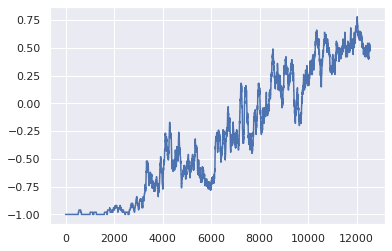

In [7]:
smoothed_rewards = []
smooth_window = 50
for i in range(smooth_window, len(all_rewards)-smooth_window):
    smoothed_rewards.append(np.mean(all_rewards[i-smooth_window:i+smooth_window]))
    
plt.plot(range(len(smoothed_rewards)), smoothed_rewards)

In [8]:
env.play([None, lambda x, y: agent.run(x, y)], width=500, height=450)

In [10]:
env.reset()
env.run([lambda x, y: agent.run(x, y), negmax])
env.render(mode='ipython', width=500, height=450)

In [13]:
torch.set_printoptions(threshold=sys.maxsize)
print(agent.cpu().state_dict())

OrderedDict([('layer1.0.weight', tensor([[[[ 1.9617e-01, -1.5123e-01,  7.7842e-02],
          [-1.9904e-01, -2.8025e-01, -3.8027e-01],
          [-1.3909e-01,  1.7684e-01, -1.6545e-01]],

         [[-5.5506e-02,  2.3520e-01,  4.9049e-02],
          [ 1.6677e-01,  1.5956e-01,  2.7860e-01],
          [-7.7018e-02,  1.6748e-01,  1.2884e-01]],

         [[ 2.9812e-02,  4.1972e-02,  9.2004e-02],
          [ 4.4786e-02, -1.4715e-01,  1.2339e-01],
          [-8.7183e-02, -2.9528e-01,  7.7399e-03]]],


        [[[-2.3671e-01,  3.6938e-02, -1.7884e-01],
          [-3.9447e-01, -1.4491e-01,  7.1673e-02],
          [-2.2370e-01,  6.7817e-02,  2.9590e-01]],

         [[-9.8150e-02,  1.7085e-02, -2.2133e-01],
          [-1.1079e-02,  3.0440e-01,  9.8772e-02],
          [ 1.0756e-01,  2.2592e-01, -1.3125e-01]],

         [[ 1.9974e-01,  1.6599e-01,  3.5236e-01],
          [ 8.9919e-02,  1.5655e-01,  1.3974e-01],
          [-1.9644e-01, -9.3328e-02, -2.6612e-02]]],


        [[[-2.4564e-01,  9.7033e-

In [10]:
agent = AgentNetwork(path='models/dqn_agent.pt', load=True)

In [34]:
agent = AgentNetwork(path='models/dqn_agent.pt', load=True)

torch.set_printoptions(threshold=sys.maxsize)
agent.path = 'models/dqn_agent.pt'
agent.save()

import zlib
agent_str = str(torch.load(agent.path))
agent_str = ' '.join(agent_str.split())
agent_str = agent_str.replace(', ', ',')
agent_str = agent_str.replace('[ ', '[')
agent_str = agent_str.replace(' [', '[')
agent_str = agent_str.replace('] ', ']')
agent_str = agent_str.replace(' ]', ']')
cstring = zlib.compress(agent_str.encode('utf-8'), 9)

print(torch.load(agent.path))

OrderedDict([('layer1.0.weight', tensor([[[[ 1.9617e-01, -1.5123e-01,  7.7842e-02],
          [-1.9904e-01, -2.8025e-01, -3.8027e-01],
          [-1.3909e-01,  1.7684e-01, -1.6545e-01]],

         [[-5.5506e-02,  2.3520e-01,  4.9049e-02],
          [ 1.6677e-01,  1.5956e-01,  2.7860e-01],
          [-7.7018e-02,  1.6748e-01,  1.2884e-01]],

         [[ 2.9812e-02,  4.1972e-02,  9.2004e-02],
          [ 4.4786e-02, -1.4715e-01,  1.2339e-01],
          [-8.7183e-02, -2.9528e-01,  7.7399e-03]]],


        [[[-2.3671e-01,  3.6938e-02, -1.7884e-01],
          [-3.9447e-01, -1.4491e-01,  7.1673e-02],
          [-2.2370e-01,  6.7817e-02,  2.9590e-01]],

         [[-9.8150e-02,  1.7085e-02, -2.2133e-01],
          [-1.1079e-02,  3.0440e-01,  9.8772e-02],
          [ 1.0756e-01,  2.2592e-01, -1.3125e-01]],

         [[ 1.9974e-01,  1.6599e-01,  3.5236e-01],
          [ 8.9919e-02,  1.5655e-01,  1.3974e-01],
          [-1.9644e-01, -9.3328e-02, -2.6612e-02]]],


        [[[-2.4564e-01,  9.7033e-

In [8]:
out = sys.stdout
submission = ke.utils.read_file('submission.py')
agent_func = ke.utils.get_last_callable(submission)
sys.stdout = out

env = ke.make("connectx", debug=True)
env.run([agent_func, agent_func])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

Success!
